In [314]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### 데이터 로드

In [315]:
df = pd.read_csv('..\\data\\Preprocessed_Bank_Customer_Churn_Prediction.csv')

In [316]:
df 

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,619,0,1,42,2,0.00,1,1,1,101348.88,1
1,608,2,1,41,1,83807.86,1,0,1,112542.58,0
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1
3,699,0,1,39,1,0.00,2,0,0,93826.63,0
4,850,2,1,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,0,0,39,5,0.00,2,1,0,96270.64,0
9996,516,0,0,35,10,57369.61,1,1,1,101699.77,0
9997,709,0,1,36,7,0.00,1,0,1,42085.58,1
9998,772,1,0,42,3,75075.31,2,1,0,92888.52,1


### 추가 전처리

#### 로그 변환

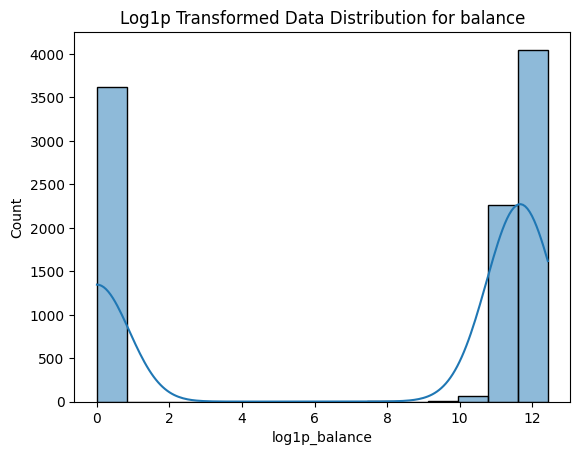

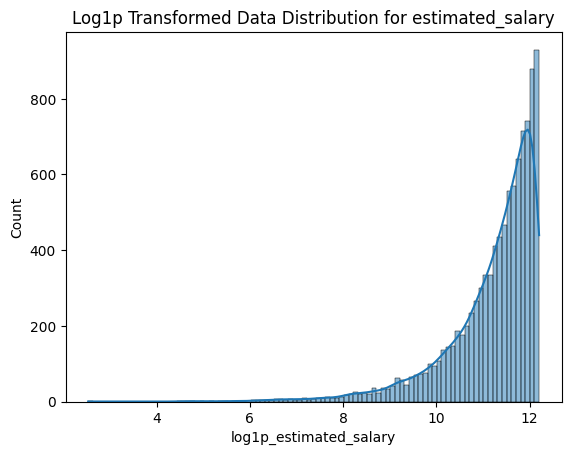

   credit_score  country  gender  age  tenure    balance  products_number  \
0           619        0       1   42       2       0.00                1   
1           608        2       1   41       1   83807.86                1   
2           502        0       1   42       8  159660.80                3   
3           699        0       1   39       1       0.00                2   
4           850        2       1   43       2  125510.82                1   

   credit_card  active_member  estimated_salary  churn  log1p_balance  \
0            1              1         101348.88      1       0.000000   
1            0              1         112542.58      0      11.336294   
2            1              0         113931.57      1      11.980813   
3            0              0          93826.63      0       0.000000   
4            1              1          79084.10      0      11.740155   

   log1p_estimated_salary  
0               11.526334  
1               11.631096  
2             

In [317]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 예시 데이터 (실제 데이터프레임 df 사용)
# df = pd.read_csv("your_data.csv")

# 원본 데이터에서 왜도가 1보다 큰 컬럼 찾기
# skewness = df.skew()
# skewed_columns = skewness[skewness > 1].index
# print("왜도가 1보다 큰 컬럼들:", skewed_columns)  # 예시: age 컬럼 확인

# 'balance'와 'estimated_salary' 컬럼을 skewed_columns 리스트에 추가
skewed_columns = ['balance', 'estimated_salary'] #, 'credit_score']  # 'balance'와 'estimated_salary' 추가

# log1p 변환 함수
def log1p_transform_columns(df, columns):
    for column in columns:
        df[f'log1p_{column}'] = np.log1p(df[column])  # np.log1p는 log(x+1)
    return df

# log1p 변환 수행
df = log1p_transform_columns(df, skewed_columns)

# log1p 변환 후 데이터 분포 시각화
for column in skewed_columns:
    sns.histplot(df[f'log1p_{column}'], kde=True)
    plt.title(f'Log1p Transformed Data Distribution for {column}')
    plt.show()

# 결과 출력
print(df.head())

# 변환된 'log1p_' 컬럼을 원래 컬럼에 대체하고, 불필요한 컬럼 제거
for column in skewed_columns:
    df[column] = df[f'log1p_{column}']
    df.drop([f'log1p_{column}'], axis=1, inplace=True)

# 최종 데이터 확인
print(df.head())


### 머신 러닝(로지스틱 회귀, k 최근접 이웃 모델)

In [318]:
!pip install imblearn

In [319]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report,roc_curve, auc
from imblearn.over_sampling import SMOTE

### 평가 함수

In [338]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def evaluation(model, X_train, X_test, y_test, threshold=0.5):  # 임계값 추가
    # 예측 확률 구하기
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 임계값을 기준으로 예측 결과 도출
    y_pred = (y_prob >= threshold).astype(int)

    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print(f"정확도: {accuracy * 100:.4f}%")

    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    print("혼동 행렬:\n", cm)

    # 정밀도: 정밀도는 예측한 클래스 1 중에서 실제로 클래스 1인 비율
    precision = precision_score(y_test, y_pred)
    print(f"정밀도: {precision:.4f}")

    # 재현율: 재현율은 실제 클래스 1 중에서 모델이 클래스 1로 예측한 비율
    recall = recall_score(y_test, y_pred)
    print(f"재현율: {recall:.4f}")

    # 분류 보고서(Precision, Recall, F1_Score 등)
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # ROC AUC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 회귀 계수 출력 (Feature Importance)
    coefficients = model.coef_[0]

    # 계수를 내림차순으로 정렬
    indices = coefficients.argsort()

    # 데이터 프레임으로 변환 
    columns = ['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary']
    
    X_train = pd.DataFrame(X_train, columns=columns)

    # 특성 중요도 시각화
    plt.figure(figsize=(10, 6))
    plt.title('Feature Importance (Logistic Regression with ElasticNet)')
    plt.barh(range(len(coefficients)), coefficients[indices], align='center')
    plt.yticks(range(len(coefficients)), X_train.columns[indices])
    plt.xlabel('Coefficient Value')
    plt.show()


#### 데이터 분할

In [321]:
# 
label_name = ['churn']
#drop_names = 'credit_card'
#drop_colum = label_name.append(drop_names)

# 다른 특성을 추가로 드랍해 봤으나 큰 차이 없음 : 'credit_card', 'tenure', 'credit_score'
X = df.drop(label_name, axis = 1)
y = df[label_name]  

# 학습 데이터와 테스트 데이터로 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [322]:
X_train.columns

Index(['credit_score', 'country', 'gender', 'age', 'tenure', 'balance',
       'products_number', 'credit_card', 'active_member', 'estimated_salary'],
      dtype='object')

In [323]:
from sklearn.preprocessing import MinMaxScaler

# 정규화 (Normalization) - 0과 1 사이로 변환
scaler = MinMaxScaler()

# 학습 데이터에 맞춰서 scaler 학습 (fit) 후, 학습 데이터 변환
X_train_normalized = scaler.fit_transform(X_train)

# 테스트 데이터에 학습된 scaler를 적용하여 변환
X_test_normalized = scaler.transform(X_test)

# 결과 확인
#print("학습 데이터 정규화:", X_train_normalized[:5])
#print("테스트 데이터 정규화:", X_test_normalized[:5])


##### 표준화

In [324]:
from sklearn.preprocessing import StandardScaler

# 표준화 (Standardization) - 평균 0, 표준편차 1로 변환
scaler = StandardScaler()

# 학습 데이터에 맞춰서 scaler 학습 (fit) 후, 학습 데이터 변환
X_train_scaled = scaler.fit_transform(X_train)

# 테스트 데이터에 학습된 scaler를 적용하여 변환
X_test_scaled = scaler.transform(X_test)

# 결과 확인
#print("학습 데이터 표준화:", X_train_scaled[:5])
#print("테스트 데이터 표준화:", X_test_scaled[:5])


#### SMOTE 오버 샘플링 (불균형 클래스 처리)

In [325]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

* 로지스틱 회귀

정확도: 47.4667%
혼동 행렬:
 [[ 854 1535]
 [  41  570]]
정밀도: 0.2708
재현율: 0.9329
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.36      0.52      2389
           1       0.27      0.93      0.42       611

    accuracy                           0.47      3000
   macro avg       0.61      0.65      0.47      3000
weighted avg       0.82      0.47      0.50      3000

AUC: 0.7884


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


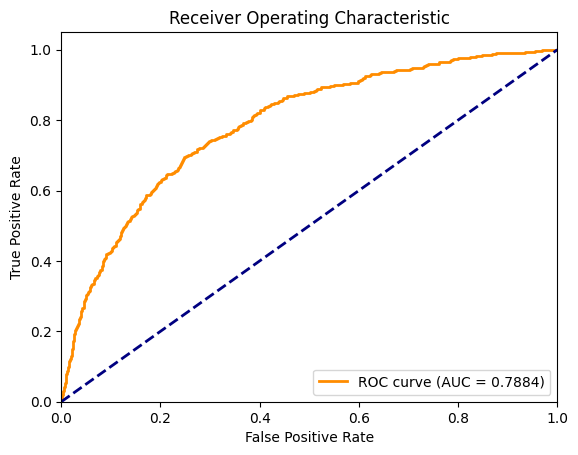

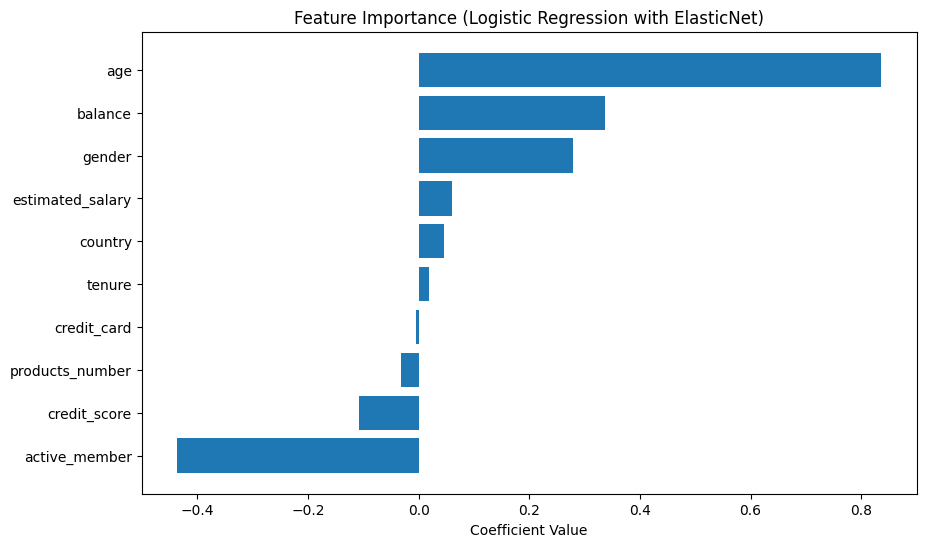

In [336]:
# 로지스틱 회귀 모델 학습
model = LogisticRegression(penalty='elasticnet', class_weight='balanced', l1_ratio=0.6, solver='saga', max_iter=20000) # 클래스 불균형 문제를 해결하기 위함, 가중치 조절을 했을 떄, 좀 더 성능이 높아지긴 하나, 크게 차이가 없음 
# model.fit(X_train, y_train)

# 예측
# y_pred = model.predict(X_test)
# y_pred_n = model.predict(X_test_normalized)
# y_pred_s = model.predict(X_test_scaled)

# 정확도 평가
# evaluation(model, X_test, y_test)
# evaluation(model, X_test_normalized, y_test)
# evaluation(model, X_train_scaled, X_test_scaled, y_test)

model.fit(X_train_smote, y_train_smote)
y_pred_ss = model.predict(X_test_scaled)

evaluation(model, X_train_smote, X_test_scaled, y_test)


* 그리드 서치

Fitting 5 folds for each of 336 candidates, totalling 1680 fits
최적의 하이퍼파라미터: {'C': 0.001, 'class_weight': 'balanced', 'l1_ratio': 0.5, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}
정확도: 73.7667%
혼동 행렬:
 [[1776  613]
 [ 174  437]]
정밀도: 0.4162
재현율: 0.7152
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.74      0.82      2389
           1       0.42      0.72      0.53       611

    accuracy                           0.74      3000
   macro avg       0.66      0.73      0.67      3000
weighted avg       0.81      0.74      0.76      3000

AUC: 0.7911


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


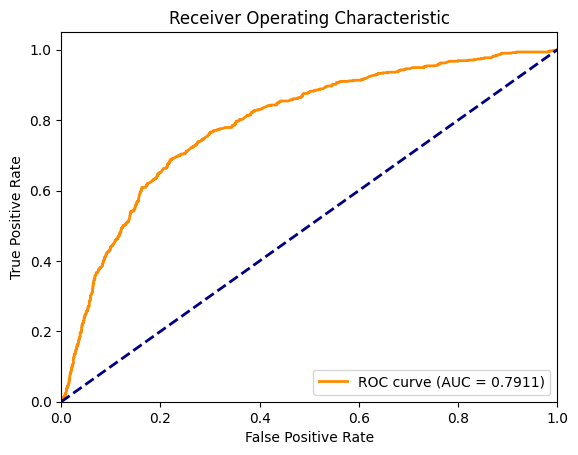

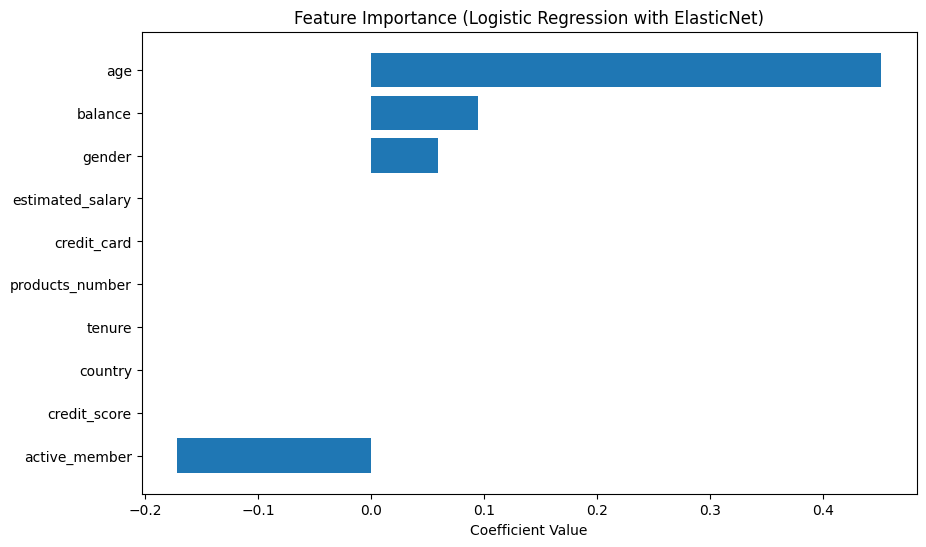

In [339]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# 하이퍼파라미터 그리드 설정
param_grid = {
    'penalty': ['elasticnet'],  # ElasticNet만 사용
    'class_weight': ['balanced', None],  # 클래스 불균형에 대한 가중치 설정
    'l1_ratio': [0.01, 0.05, 0.1, 0.3, 0.5, 0.7, 0.9],  # Lasso와 Ridge의 비율
    'solver': ['saga'],  # ElasticNet을 지원하는 solver
    'max_iter': [100, 1000, 5000, 10000],  # 반복 횟수
    'C': [0.001, 0.01, 0.1, 1, 10, 100]  # 규제 강도, 더 작은 값은 더 강한 규제를 의미
}

# 로지스틱 회귀 모델 정의
model = LogisticRegression()

# 그리드 서치 수행 (5-fold 교차 검증)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring='accuracy')

# 그리드 서치 학습
grid_search.fit(X_train_smote, y_train_smote)

# 최적 하이퍼파라미터 출력
print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")

# 최적 모델로 예측
best_model = grid_search.best_estimator_

# 예측
y_pred_best = best_model.predict(X_test_scaled)

# 성능 평가
evaluation(best_model, X_train_smote, X_test_scaled, y_test)


* 표준화를 실시한 데이터를 넣은 모델이 가장 적합
    - 재현율이 가장 높다, F1 점수와 AUC가 뛰어나며, 고객 이탈을 예측하는 데 가장 효과적임. 
    - 이 모델은 이탈 고객을 놓치지 않고 잘 예측하므로 목적에 가장 잘 부합 

* SMOTE 
    - SMOTE 적용 후 모델이 이탈 고객을 더 잘 예측하는 모델로, 재현율이 높고 AUC가 우수.
    - SMOTE 없는 모델은 정확도가 높지만, 이탈 고객을 잘 예측하지 못하는 경향이 있음.
    - Smote의 경우 credit_card, tenure, country 칼럼은 제거해도 될 것 같음

* 임계값(Threshold) 조정
    - 0.3 : 정밀도 0.2 , 재현율 0.92
    - 0.7 : 정확도 0.8 이상, 정밀도 0.5, 재현율 0.4 
    - 재현율 수치상 0.3 인 경우가 조금 더 목적에 부합하긴 하나, 전체적인 수치가 너무 떨어짐. 일단 기존의 0.5로 적용하기로 결정

* 그리드 서치를 하이퍼파라매타 튜닝을 했지만 성능이 크게 개선되지 않음

* 결론: SMOTE 까지 적용한게 최선의 모델, 재현율을 우선한다면 0.3으로 조절한 것 추천, 전체적인 성능이 우선 시 된다면 0.5 추천

#### 스케일링

* K - 최근접 이웃 모델

In [330]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
# K-최근접 이웃 모델 학습 및 예측
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')  # k 값을 13으로 설정

# 모델 학습 및 예측 (기본 데이터)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# 모델 학습 및 예측 (정규화된 데이터)
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train_normalized, y_train)
y_pred_normalized = knn.predict(X_test_normalized)

# 모델 학습 및 예측 (표준화된 데이터)
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)

# 모델 평가 (정규화된 데이터)
print("Evaluation on Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 모델 평가 (정규화된 데이터)
print("Evaluation on Normalized Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_normalized):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_normalized))
print("Classification Report:")
print(classification_report(y_test, y_pred_normalized))

# 모델 평가 (표준화된 데이터)
print("Evaluation on Scaled Data:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_scaled):.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_scaled))
print("Classification Report:")
print(classification_report(y_test, y_pred_scaled))



c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Evaluation on Data:
Accuracy: 0.8063
Confusion Matrix:
[[2278  111]
 [ 470  141]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2389
           1       0.56      0.23      0.33       611

    accuracy                           0.81      3000
   macro avg       0.69      0.59      0.61      3000
weighted avg       0.77      0.81      0.77      3000

Evaluation on Normalized Data:
Accuracy: 0.8243
Confusion Matrix:
[[2311   78]
 [ 449  162]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2389
           1       0.68      0.27      0.38       611

    accuracy                           0.82      3000
   macro avg       0.76      0.62      0.64      3000
weighted avg       0.80      0.82      0.79      3000

Evaluation on Scaled Data:
Accuracy: 0.8413
Confusion Matrix:
[[2315   74]
 [ 402  209]]
Classification Report:
             

* 표준화된 데이터에서 가장 좋은 성능을 보임

In [258]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)

grid_search.fit(X_train, y_train)
# 최적의 k 값 출력
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")

grid_search.fit(X_train_normalized, y_train)
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")

grid_search.fit(X_train_scaled, y_train)
print(f"Best k value: {grid_search.best_params_['n_neighbors']}")


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classif

Best k value: 29


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classif

Best k value: 11


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classif

Best k value: 11


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


* 기본 데이터와 정규화된 데이터는 특성들의 분포가 일관되지 않거나 고르게 분포하지 않아 n_neighbors가 늘어날수록 성능이 계속해서 증가한다.
* 표준화된 데이터는 이미 각 특성이 잘 조정되어 있기 때문에 n_neighbors가 13일 때 가장 최적의 성능을 보일 수 있으며, 그 이후에는 성능이 더 이상 개선되지 않거나 오히려 감소할 수 있다.
* 이것에서도 표준화된 데이터를 사용하는 것이 적합하다고 판단함.

##### 추가적으로 실시할 수 있는 방법 
* k 값을 좀 더 넓은 범위에서 튜닝
* 거리 척도(Distance Metric) 변경 
* 가중치 조정 
* 특성 선택 및 차원 축소

* 해볼 수 있는 거 다 해본 버전


--- 평가: 전처리 및 SMOTE 없이 원본 모델 ---
정확도: 76.4000%
혼동 행렬:
 [[2230  159]
 [ 549   62]]
정밀도: 0.2805
재현율: 0.1015
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.93      0.86      2389
           1       0.28      0.10      0.15       611

    accuracy                           0.76      3000
   macro avg       0.54      0.52      0.51      3000
weighted avg       0.70      0.76      0.72      3000

AUC: 0.5685


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


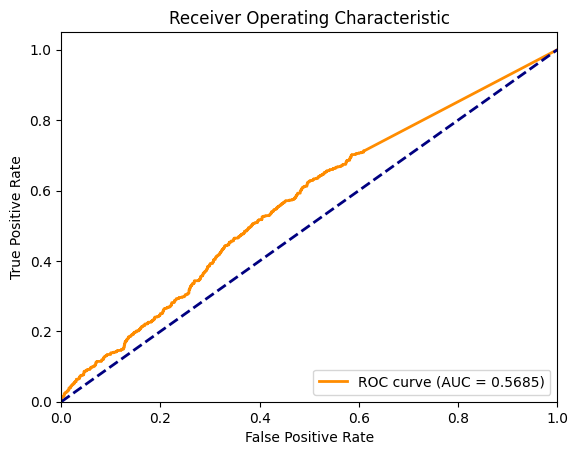


--- 평가: SMOTE 적용 후 모델 ---


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


정확도: 51.5333%
혼동 행렬:
 [[1122 1267]
 [ 187  424]]
정밀도: 0.2507
재현율: 0.6939
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.47      0.61      2389
           1       0.25      0.69      0.37       611

    accuracy                           0.52      3000
   macro avg       0.55      0.58      0.49      3000
weighted avg       0.73      0.52      0.56      3000

AUC: 0.6245


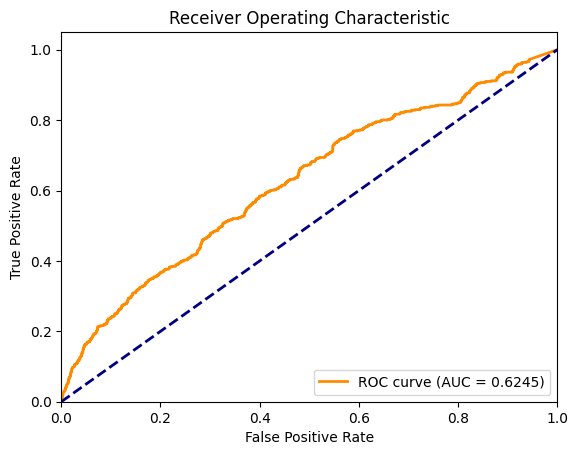

Fitting 5 folds for each of 16 candidates, totalling 80 fits


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(



--- 평가: 하이퍼파라미터 튜닝 후 모델 ---
최적의 하이퍼파라미터: {'n_neighbors': 11, 'weights': 'distance'}
정확도: 64.7000%
혼동 행렬:
 [[1639  750]
 [ 309  302]]
정밀도: 0.2871
재현율: 0.4943
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.69      0.76      2389
           1       0.29      0.49      0.36       611

    accuracy                           0.65      3000
   macro avg       0.56      0.59      0.56      3000
weighted avg       0.73      0.65      0.68      3000

AUC: 0.6189


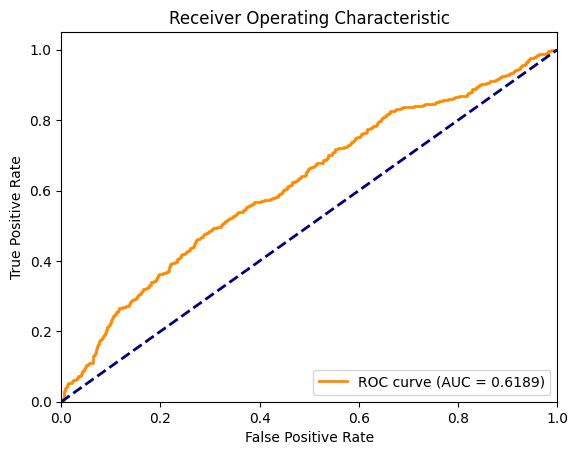

In [ ]:
def knn_with_smote(X_train, X_test, y_train, y_test, X_train_smote, y_train_smote):
    """
    SMOTE를 적용한 KNN 모델 학습 및 평가 함수.
    
    Parameters:
    - X_train, X_test: 학습 및 테스트 특성
    - y_train, y_test: 학습 및 테스트 라벨
    - X_train_smote, y_train_smote: SMOTE가 적용된 학습 특성 및 라벨
    
    Returns:
    - None
    """
    # 모델 정의
    knn = KNeighborsClassifier(weights='distance')

    # 원본 모델 평가 (전처리 안한 모델)
    print("\n--- 평가: 전처리 및 SMOTE 없이 원본 모델 ---")
    knn.fit(X_train, y_train)
    evaluation(knn, X_train, X_test, y_train, y_test)

    # SMOTE와 표준화를 적용한 모델 평가
    print("\n--- 평가: SMOTE 적용 후 모델 ---")
    knn.fit(X_train_smote, y_train_smote)
    evaluation(knn, X_train_smote, X_test, y_train_smote, y_test)

    # 하이퍼파라미터 그리드 설정 (k 값 조정)
    param_grid = {
        'n_neighbors': [11, 13, 15, 17, 19, 21, 23, 25],
        'weights': ['uniform', 'distance'],
    }
    
    # 그리드 서치를 통해 하이퍼파라미터 최적화
    grid_search = GridSearchCV(knn, param_grid, cv=5, n_jobs=-1, verbose=1)
    grid_search.fit(X_train_smote, y_train_smote)
    
    # 최적의 하이퍼파라미터 출력
    print(f"\n--- 평가: 하이퍼파라미터 튜닝 후 모델 ---")
    print(f"최적의 하이퍼파라미터: {grid_search.best_params_}")
    
    # 최적 모델로 예측
    best_model = grid_search.best_estimator_

    # 성능 평가
    evaluation(best_model, X_train_smote, X_test, y_train_smote, y_test)

# 모델 학습 및 평가 실행
knn_with_smote(X_train, X_test, y_train, y_test, X_train_smote, y_train_smote)


* 추가 처리 후 오히려 성능 떨어짐 

* 최종 추천 모델: 로지스틱 회귀 모델 

In [333]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report, roc_curve, auc
import matplotlib.pyplot as plt

def knn_evaluation(model, X_train, X_test, y_train, y_test, threshold=0.5):  # 임계값 추가
    # 예측 확률 구하기
    y_prob = model.predict_proba(X_test)[:, 1]
    
    # 임계값을 기준으로 예측 결과 도출
    y_pred = (y_prob >= threshold).astype(int)

    # 정확도
    accuracy = accuracy_score(y_test, y_pred)
    print(f"정확도: {accuracy * 100:.4f}%")

    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    print("혼동 행렬:\n", cm)

    # 정밀도: 정밀도는 예측한 클래스 1 중에서 실제로 클래스 1인 비율
    precision = precision_score(y_test, y_pred)
    print(f"정밀도: {precision:.4f}")

    # 재현율: 재현율은 실제 클래스 1 중에서 모델이 클래스 1로 예측한 비율
    recall = recall_score(y_test, y_pred)
    print(f"재현율: {recall:.4f}")

    # 분류 보고서(Precision, Recall, F1_Score 등)
    report = classification_report(y_test, y_pred)
    print("Classification Report:")
    print(report)

    # ROC AUC
    fpr, tpr, thresholds_roc = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 특성 중요도 (KNN에서는 중요도 계산이 없으므로, 대신 k-최근접 이웃에 대한 시각화를 생략)
    # 하지만 KNN은 계수나 가중치가 없기 때문에 이 부분은 제외하거나 다른 방식으로 시각화할 수 있습니다.
    # print("KNN 모델은 계수 기반 특성 중요도 표시가 어렵습니다.")



--- 평가: 기본 데이터 ---
정확도: 80.6333%
혼동 행렬:
 [[2278  111]
 [ 470  141]]
정밀도: 0.5595
재현율: 0.2308
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.95      0.89      2389
           1       0.56      0.23      0.33       611

    accuracy                           0.81      3000
   macro avg       0.69      0.59      0.61      3000
weighted avg       0.77      0.81      0.77      3000

AUC: 0.7416


c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


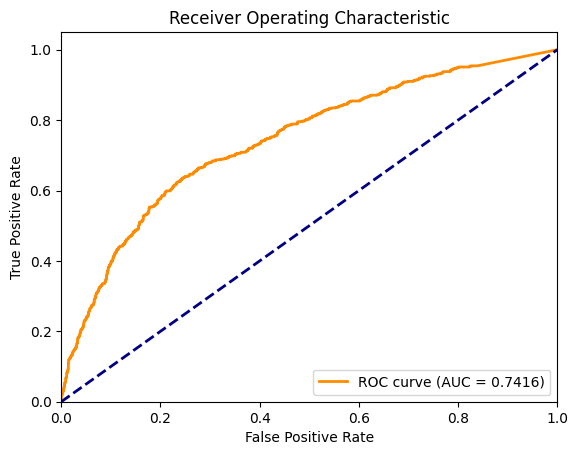

c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



--- 평가: 정규화된 데이터 ---
정확도: 82.4333%
혼동 행렬:
 [[2311   78]
 [ 449  162]]
정밀도: 0.6750
재현율: 0.2651
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      2389
           1       0.68      0.27      0.38       611

    accuracy                           0.82      3000
   macro avg       0.76      0.62      0.64      3000
weighted avg       0.80      0.82      0.79      3000

AUC: 0.8042


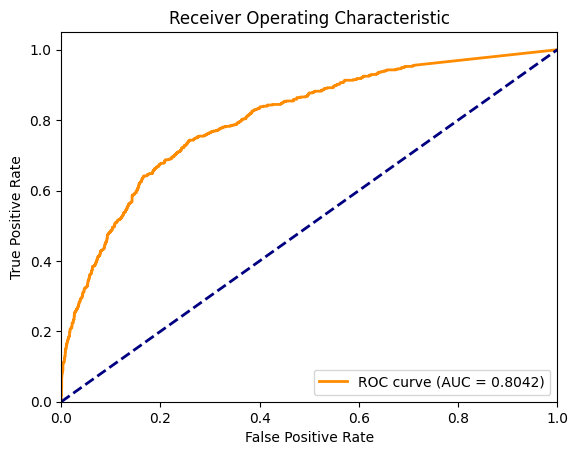

c:\Users\Playdata\AppData\Local\anaconda3\envs\pystudy_env\Lib\site-packages\sklearn\neighbors\_classification.py:238: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)



--- 평가: 표준화된 데이터 ---
정확도: 84.1333%
혼동 행렬:
 [[2315   74]
 [ 402  209]]
정밀도: 0.7385
재현율: 0.3421
Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      2389
           1       0.74      0.34      0.47       611

    accuracy                           0.84      3000
   macro avg       0.80      0.66      0.69      3000
weighted avg       0.83      0.84      0.82      3000

AUC: 0.8181


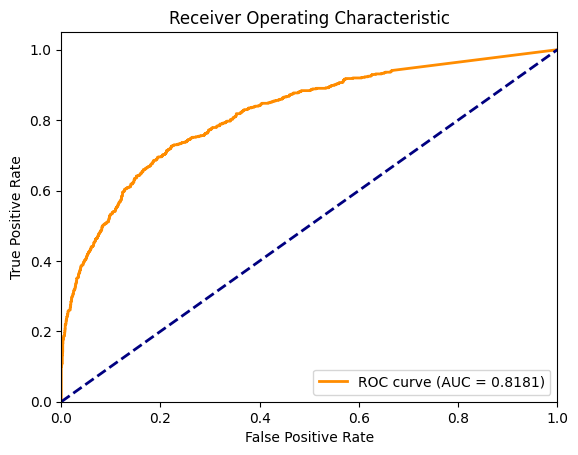

In [334]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# K-최근접 이웃 모델 학습 및 예측
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')  # k 값을 13으로 설정

# 모델 학습 및 예측 (기본 데이터)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

# 평가 (기본 데이터)
print("\n--- 평가: 기본 데이터 ---")
knn_evaluation(knn, X_train, X_test, y_train, y_test, threshold=0.5)

# 모델 학습 및 예측 (정규화된 데이터)
knn = KNeighborsClassifier(n_neighbors=15, weights='distance')
knn.fit(X_train_normalized, y_train)
y_pred_normalized = knn.predict(X_test_normalized)

# 평가 (정규화된 데이터)
print("\n--- 평가: 정규화된 데이터 ---")
knn_evaluation(knn, X_train_normalized, X_test_normalized, y_train, y_test, threshold=0.5)

# 모델 학습 및 예측 (표준화된 데이터)
knn = KNeighborsClassifier(n_neighbors=13, weights='distance')
knn.fit(X_train_scaled, y_train)
y_pred_scaled = knn.predict(X_test_scaled)

# 평가 (표준화된 데이터)
print("\n--- 평가: 표준화된 데이터 ---")
knn_evaluation(knn, X_train_scaled, X_test_scaled, y_train, y_test, threshold=0.5)
